<a href="https://colab.research.google.com/github/codrae/timeseries-dl-models/blob/main/AMPds2_LSTM_Resample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.pyplot as plt
import os
import random

In [76]:
# 시드 값 고정
seed = 42

# Python 내장 해시 함수의 시드를 고정하여 재현성을 확보 (Python 3.3 이상에서만 적용)
os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed) # Python의 random 모듈
np.random.seed(seed )# NumPy의 난수 생성기
torch.manual_seed(seed) # PyTorch의 난수 생성기

torch.cuda.manual_seed(seed) #GPU의 난수 생성기
torch.backends.cudnn.deterministic = True # CuDNN을 사용할 때, 비결정론적 알고리즘을 사용하지 않도록 설정
torch.backends.cudnn.benchmark = False # CuDNN의 벤치마크 기능을 비활성화하여 매번 동일한 연산 경로가 사용되도록 설정

# GPU가 사용 가능하면 CUDA 장치로 설정, 그렇지 않으면 CPU로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 설정된 장치(device) 출력
device

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/B2E_P.csv')
df.set_index('date', inplace=True)
df.head()

,P
date,
2012-04-01 07:00:00+00:00,58
2012-04-01 07:01:00+00:00,58
2012-04-01 07:02:00+00:00,8
2012-04-01 07:03:00+00:00,7
2012-04-01 07:04:00+00:00,8


                             P
date                          
2012-04-03 03:26:00+00:00  130
2012-04-03 03:27:00+00:00  133
2012-04-03 03:28:00+00:00  129
2012-04-03 03:29:00+00:00  132
2012-04-03 03:30:00+00:00  127
...                        ...
2013-04-01 05:33:00+00:00  149
2013-04-01 05:34:00+00:00  151
2013-04-01 06:01:00+00:00  152
2013-04-01 06:02:00+00:00  152
2013-04-01 06:03:00+00:00  152

[10217 rows x 1 columns]
이상치 수: 10217
이상치 비율: 1.94%


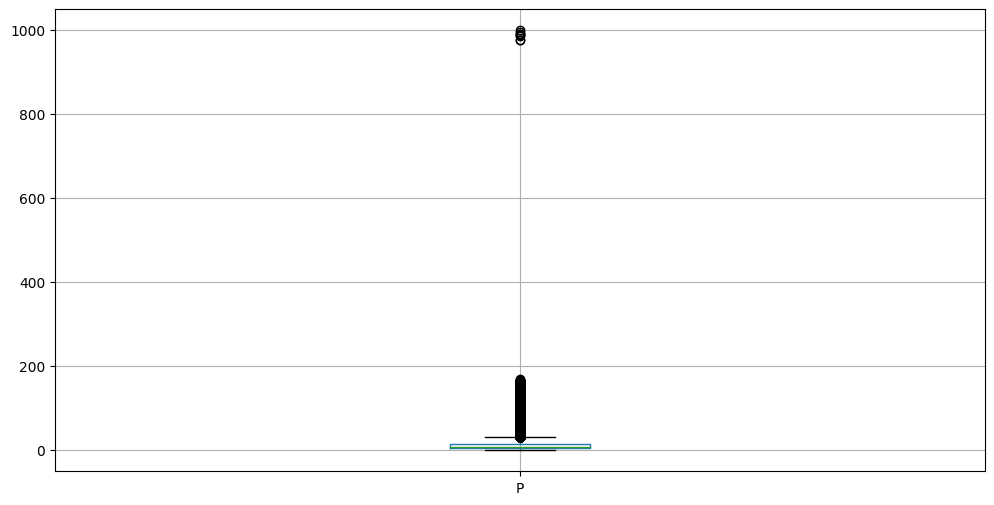

In [78]:
outlier_detected = df[np.abs((df['P'] - df['P'].mean()) / df['P'].std()) > 3]
print(outlier_detected)
outlier_ratio = len(outlier_detected)
print(f"이상치 수: {outlier_ratio}")
print(f"이상치 비율: {round(outlier_ratio/len(df)*100,2)}%")

df.boxplot(figsize=(12, 6))
plt.show()

In [79]:
df = df[df['P'] < 800]

In [80]:
# 각 열의 결측치 수
print(df.isnull().sum())

P    0
dtype: int64


In [81]:
df['date'] = pd.to_datetime(df.index)  # datetime 형식으로 변환
df.set_index('date', inplace=True)  # 'date'를 인덱스로 설정
df = df.resample('D').mean()
df.head()

,P
date,
2012-04-01 00:00:00+00:00,14.726471
2012-04-02 00:00:00+00:00,13.976389
2012-04-03 00:00:00+00:00,19.152778
2012-04-04 00:00:00+00:00,12.292361
2012-04-05 00:00:00+00:00,19.579167


In [82]:
df.tail()

,P
date,
2013-03-28 00:00:00+00:00,35.241667
2013-03-29 00:00:00+00:00,18.197222
2013-03-30 00:00:00+00:00,25.930556
2013-03-31 00:00:00+00:00,24.110417
2013-04-01 00:00:00+00:00,57.002381


In [83]:
# 데이터 로드 및 전처리 (데이터셋 나누기 전에 수행하는 것이 좋음!)
def load_data_from_csv(df, column_name):
    data = df
    data = data[column_name].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

data, scaler = load_data_from_csv(df, 'P')

In [84]:
# 데이터셋 클래스 정의
class B2EDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        y = self.data[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [85]:
# 데이터셋 생성
window_size = 7
dataset = B2EDataset(data, window_size)

# 훈련/검증 데이터 분리 (80% 훈련 데이터, 20% 테스트 데이터)
train_size = int(len(dataset) * 0.80)

# 학습과 테스트 데이터셋을 슬라이싱으로 나누기
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [86]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, output_size=1, dropout=0.2): # LSTM 전체 모델 정의
        super(LSTMModel, self).__init__() # Moudle(부모 클래스의 생성자 호출
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # nn.LSTM을 통해 LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # 출력 크기 조정 (FC레이어 = 선형 변환 레이어 정의)
        self.fc = nn.Linear(hidden_size, output_size)

        # 가중치와 편향을 초기화
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x): # x는 입력 데이터 (하나의 batch)
        # 초기 은닉 상태와 셀 상태 정의
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시퀀스의 출력만 선택하여 FC 레이어에 통과
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 추가

        return out

In [87]:
# 모델 학습 함수
def train_model(train_loader, num_epochs=1000, learning_rate=0.001, device=device):
    model = LSTMModel().to(device)
    criterion = nn.MSELoss() #손실 함수
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #최적 가중치를 찾아주는 알고리즘

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for seqs, targets in train_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return model

In [88]:
# 모델 학습
model = train_model(train_loader, device=device)

Epoch 1/1000, Loss: 0.0616
Epoch 2/1000, Loss: 0.0484
Epoch 3/1000, Loss: 0.0390
Epoch 4/1000, Loss: 0.0348
Epoch 5/1000, Loss: 0.0327
Epoch 6/1000, Loss: 0.0321
Epoch 7/1000, Loss: 0.0312
Epoch 8/1000, Loss: 0.0313
Epoch 9/1000, Loss: 0.0301
Epoch 10/1000, Loss: 0.0295
Epoch 11/1000, Loss: 0.0289
Epoch 12/1000, Loss: 0.0281
Epoch 13/1000, Loss: 0.0272
Epoch 14/1000, Loss: 0.0261
Epoch 15/1000, Loss: 0.0254
Epoch 16/1000, Loss: 0.0247
Epoch 17/1000, Loss: 0.0233
Epoch 18/1000, Loss: 0.0223
Epoch 19/1000, Loss: 0.0213
Epoch 20/1000, Loss: 0.0199
Epoch 21/1000, Loss: 0.0189
Epoch 22/1000, Loss: 0.0173
Epoch 23/1000, Loss: 0.0165
Epoch 24/1000, Loss: 0.0152
Epoch 25/1000, Loss: 0.0151
Epoch 26/1000, Loss: 0.0146
Epoch 27/1000, Loss: 0.0144
Epoch 28/1000, Loss: 0.0136
Epoch 29/1000, Loss: 0.0136
Epoch 30/1000, Loss: 0.0133
Epoch 31/1000, Loss: 0.0129
Epoch 32/1000, Loss: 0.0131
Epoch 33/1000, Loss: 0.0128
Epoch 34/1000, Loss: 0.0128
Epoch 35/1000, Loss: 0.0130
Epoch 36/1000, Loss: 0.0127
E

In [89]:
# 예측 함수
def predict(model, test_loader, scaler, device=device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for seqs, targets in test_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            outputs = model(seqs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions, actuals

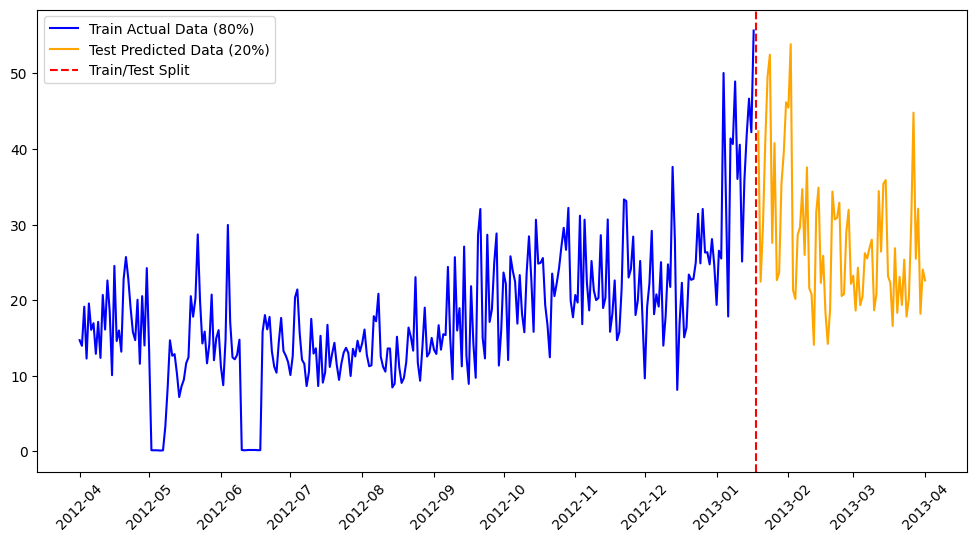

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates  # 날짜 관련 모듈

# 예측 데이터 (테스트 데이터에 대한 예측)
predictions, actuals = predict(model, test_loader, scaler, device=device)

# 데이터의 날짜 범위를 생성 (df를 사용)
total_length = len(df)  # 기존 df의 길이
split_point = int(0.8 * total_length)  # 데이터셋의 80% 지점에서 분할

# 날짜 인덱스 생성 (df에 있는 인덱스를 사용)
date_range = df.index

# DataFrame 생성 (actuals와 predictions)
actuals_df = pd.DataFrame(actuals, index=date_range[split_point+1:], columns=['P'])  # 테스트 데이터 실제값
predictions_df = pd.DataFrame(predictions, index=date_range[split_point+1:], columns=['P'])  # 테스트 데이터 예측값

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

# 훈련 데이터(80%) 실제값 시각화 (df의 앞 80% 사용)
ax.plot(df.index[:split_point], df['P'][:split_point], label='Train Actual Data (80%)', color='blue')

# 테스트 데이터(20%) 실제값과 예측값 시각화
# ax.plot(actuals_df.index, actuals_df['P'], label='Test Actual Data (20%)', color='green')
ax.plot(predictions_df.index, predictions_df['P'], label='Test Predicted Data (20%)', color='orange')

# x축 레이블을 월별로 표시 (MonthLocator 사용)
ax.xaxis.set_major_locator(mdates.MonthLocator())  # 매월 레이블 표시
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연도-월 형식으로 레이블 포맷

# x축 레이블 회전
plt.xticks(rotation=45)

# 데이터셋 분할점을 나타내는 빨간 점선 추가 (80:20 비율)
plt.axvline(x=df.index[split_point], color='red', linestyle='--', label='Train/Test Split')

# 범례 추가 및 시각화
plt.legend()
plt.show()


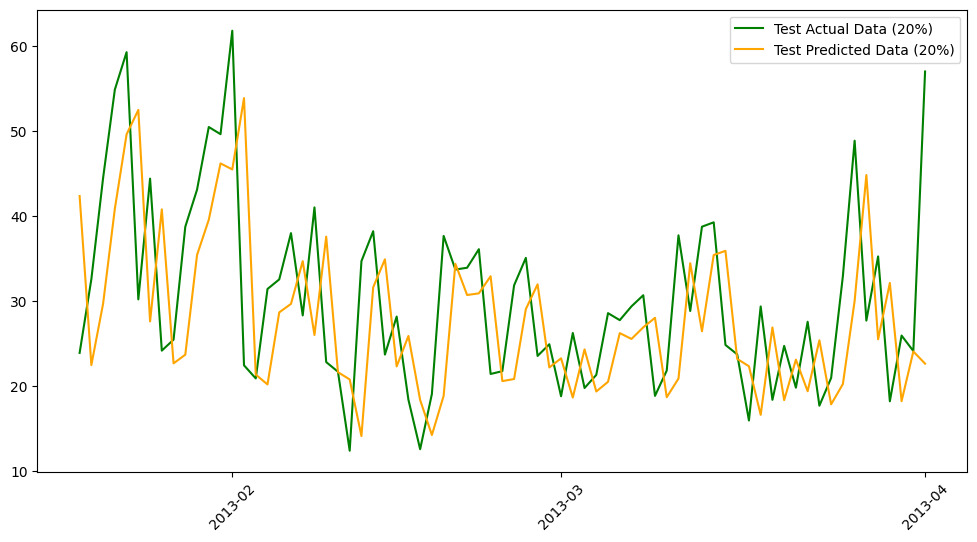

In [109]:
# prompt: 예측 20%부분에 대해서만 actuals, predictions 그래프 시각화

import pandas as pd
import matplotlib.pyplot as plt
# 데이터의 날짜 범위를 생성 (df를 사용)
total_length = len(df)  # 기존 df의 길이
split_point = int(0.8 * total_length)  # 데이터셋의 80% 지점에서 분할

# 날짜 인덱스 생성 (df에 있는 인덱스를 사용)
date_range = df.index

# DataFrame 생성 (actuals와 predictions)
actuals_df = pd.DataFrame(actuals, index=date_range[split_point+1:], columns=['P'])  # 테스트 데이터 실제값
predictions_df = pd.DataFrame(predictions, index=date_range[split_point+1:], columns=['P'])  # 테스트 데이터 예측값

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

# 테스트 데이터(20%) 실제값과 예측값 시각화
ax.plot(actuals_df.index, actuals_df['P'], label='Test Actual Data (20%)', color='green')
ax.plot(predictions_df.index, predictions_df['P'], label='Test Predicted Data (20%)', color='orange')

# x축 레이블을 월별로 표시 (MonthLocator 사용)
ax.xaxis.set_major_locator(mdates.MonthLocator())  # 매월 레이블 표시
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연도-월 형식으로 레이블 포맷

# x축 레이블 회전
plt.xticks(rotation=45)

# 범례 추가 및 시각화
plt.legend()
plt.show()


In [108]:
# prompt: MAE, RMSE 측정 및 출력

import numpy as np
# MAE 및 RMSE 계산
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 9.3051
RMSE: 11.5015
